# Undertale & Deltarune Soundtrack Generator

---

## Table of Contents

0. [**Table of Contents**](#Table-of-Contents)

1. [**Imports**](#Imports)

2. [**Data Processing**](#Data-Processing)

    2.1 [Data Loading](#Data-Loading)
    
    2.2 [Data Preprocessing](#Data-Preprocessing)
    
    2.3 [Dataset & Dataloader Definition](#Dataset-&-Dataloader-Definition)
    
3. [**Model Definition**](#Model-Definition)
    
4. [**Hyperparameters & Instantiation**](#Hyperparameters-&-Instantiation)

5. [**Training**](#Training)
    
    4.1 [Training Function](#Training-Function)
    
    4.2 [Training Session](#Training-Session)

6. [**Loading the Best Model**](#Loading-the-Best-Model)

7. [**Generation**](#Generation)
    
    6.1 [Sampling Function](#Sampling-Function)

    6.2 [Generation Function](#Generation-Function)
    
    6.3 [Music Generation](#Music-Generation)

8. [**Final Summary, Notes, and Thoughts**](#Final-Summary,-Notes,-and-Thoughts)

---

## Imports
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

Import required packages

In [1]:
import os                                         # File handling
import itertools                                  # chain() for merging lists
import random                                     # Shuffling
import collections                                # Useful tools like Counter, OrderedDict
import math                                       # For... math
from decimal import Decimal                       # Scientific notations in string formatting
from time import time                             # For use in progress bar

import tqdm.auto as tqdm                          # Progress bar

import torch                                      # Deep Learning Framework
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt                   # Plotting training progress
from matplotlib.ticker import AutoLocator
%matplotlib inline

fig_bg_color = "lightsteelblue"
plot_bg_color = "slategray"
fontsize = 20

---

## Data Processing
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

### Data Loading
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

Read the text files in the target directory.

Do some processing to make sure the texts are clean.

In [2]:
def get_texts(texts_dir):

    if not os.path.isdir(texts_dir):
        raise FileNotFoundError("given text directory not found: {}".format(texts_dir))

    texts = []
    
    for text_path in (file.path for file in os.scandir(texts_dir) if file.is_file() and file.name.endswith(".txt")):
        with open(file=text_path, mode='r', encoding="utf-8") as text_file:
            
            text = text_file.read().strip()

            if not text.replace(' ', '').isdigit():
                raise RuntimeError("one or more characters other than digits and white spaces are detected: {}".format(text_path))

            while "  " in text:
                text = text.replace("  ", ' ')
            
            texts.append((text_path, text))
    
    return dict(texts)


[(os.path.split(text_path)[1], text[:20]) for text_path, text in get_texts("./source/converted_texts").items()]

[('Deltarune_-_Lancer_Battle.txt', '62 0 62 0 62 0 0 0 0'),
 ('Deltarune_-_The_Chase.txt', '24 31 0 24 31 0 24 3'),
 ('Undertale_-_031_Waterfall.txt', '65 0 65 0 65 0 65 0 '),
 ('School_-_DeltaRune.txt', '38 66 0 38 66 0 38 6'),
 ('DELTARUNE_-_Lancer_piano_solo.txt', '0 0 0 62 0 62 0 62 0'),
 ('Undertale_-_100_MEGALOVANIA.txt', '63 0 63 0 63 0 63 0 '),
 ('Deltarune_-_Rude_Buster_Playable.txt', '31 43 0 31 43 0 31 4'),
 ('Undertale_-_Hopes_and_Dreams.txt', '64 78 0 64 78 0 64 7'),
 ('Deltarune_-_Dont_Forget_Ending_Theme_Solo_Piano_Version.txt',
  '77 0 77 0 77 0 77 0 '),
 ('Undertale_-_043_Temmie_Village.txt', '49 0 49 0 49 0 49 0 '),
 ('Undertale_-_068_Death_by_Glamour.txt', '41 0 41 0 41 0 41 0 '),
 ('Before_the_Story_Deltarune_-_Arranged_for_piano_.txt',
  '48 0 48 0 48 0 48 0 '),
 ('Undertale_-_SAVE_the_World.txt', '45 57 67 0 45 57 67 '),
 ('Vs._Susie_Deltarune_-_Arranged_for_Piano.txt', '47 0 47 0 47 0 47 0 '),
 ('Undertale_-_Bonetrousle.txt', '37 0 37 0 37 0 37 0 '),
 ('Undertale

### Data Preprocessing
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

Get integers out of the text and make lists of ints.

These lists can be used for the input of the models, or be further processed to compress or simplify the sequences.

In [3]:
def texts_to_intlists(text_list):
    
    intlists = []
    
    for i, text in enumerate(iterable=text_list):
        
        int_strings = text.split(' ')
        
        if not all(int_str.isdigit() for int_str in int_strings):
            raise RuntimeError("non-digit string detected in text {}".format(i))

        ints = [int(int_str) for int_str in int_strings]
        
        intlists.append(ints)
        
    return intlists


print([ints[:10] for ints in texts_to_intlists(get_texts("./source/converted_texts").values())])

[[62, 0, 62, 0, 62, 0, 0, 0, 0, 65], [24, 31, 0, 24, 31, 0, 24, 31, 0, 24], [65, 0, 65, 0, 65, 0, 65, 0, 65, 0], [38, 66, 0, 38, 66, 0, 38, 66, 0, 38], [0, 0, 0, 62, 0, 62, 0, 62, 0, 62], [63, 0, 63, 0, 63, 0, 63, 0, 0, 63], [31, 43, 0, 31, 43, 0, 31, 43, 0, 31], [64, 78, 0, 64, 78, 0, 64, 78, 0, 64], [77, 0, 77, 0, 77, 0, 77, 0, 77, 0], [49, 0, 49, 0, 49, 0, 49, 0, 49, 0], [41, 0, 41, 0, 41, 0, 41, 0, 41, 0], [48, 0, 48, 0, 48, 0, 48, 0, 48, 0], [45, 57, 67, 0, 45, 57, 67, 0, 45, 57], [47, 0, 47, 0, 47, 0, 47, 0, 47, 0], [37, 0, 37, 0, 37, 0, 37, 0, 37, 0], [49, 0, 49, 0, 49, 52, 0, 49, 52, 56], [32, 36, 39, 68, 0, 32, 36, 39, 68, 0], [47, 54, 69, 0, 47, 54, 69, 0, 47, 54], [39, 61, 65, 0, 39, 61, 65, 0, 39, 61], [88, 0, 88, 0, 88, 0, 88, 0, 88, 0], [46, 0, 46, 0, 46, 0, 46, 0, 46, 0], [58, 70, 0, 58, 70, 0, 58, 70, 0, 58], [27, 39, 0, 27, 39, 0, 27, 39, 0, 27], [67, 0, 67, 0, 67, 0, 67, 0, 67, 0], [37, 49, 0, 37, 49, 0, 37, 49, 0, 37], [39, 0, 39, 0, 39, 0, 39, 0, 39, 0], [44, 68, 0,

To use "words" as the input and output instead of "characters",

consider '0's as spaces and find all existing words in the texts.

(Here, each word becomes a "token")

We can also tokenize the duration of each word to reduce the

repetition of words that appear several times in a row.

In [4]:
def tokenize(intlists, max_repeat_encoding=0, return_ratios=False):
    assert isinstance(max_repeat_encoding, int) and max_repeat_encoding >= -1 # -1 for no limit
    
    encode_repetition = (max_repeat_encoding != 0)
    if encode_repetition:
        observed_repeats = []
    
    counter = collections.Counter() # Note: repetition tokens are not counted. They are appended to the dictionary later.
    if return_ratios:
        measure = collections.Counter()
    tokenized_lists = []
    
    for intlist in intlists:
        if encode_repetition:
            last_token = None
            n_repeats = 0
        token = []
        tokenized = []
        for int_val in intlist:
            if int_val != 0:
                token.append(int_val)
            else:
                token = tuple(sorted(token))
                
                if encode_repetition:
                    if last_token == token:
                        if n_repeats == max_repeat_encoding:
                            tokenized.append(("<REPEAT>", n_repeats))
                            if return_ratios:
                                measure.update((("<REPEAT>", n_repeats),))
                            n_repeats = 1
                        else:
                            n_repeats += 1
                            if n_repeats not in observed_repeats:
                                observed_repeats.append(n_repeats)
                    else:
                        if n_repeats != 0:
                            tokenized.append(("<REPEAT>", n_repeats))
                            if return_ratios:
                                measure.update((("<REPEAT>", n_repeats),))
                        counter.update((token,))
                        if return_ratios:
                            measure.update((token,))
                        tokenized.append(token)
                        last_token = token
                        n_repeats = 0

                else:
                    counter.update((token,))
                    if return_ratios:
                        measure.update((token,))
                    tokenized.append(token)
                token = []
        tokenized_lists.append(tokenized)
    
    tokens_token_to_idx = collections.OrderedDict((token_key, i) for i, (token_key, _) in enumerate(counter.most_common()))
    if encode_repetition:
        tokens_token_to_idx.update([(("<REPEAT>", r), i) for i, r in enumerate(observed_repeats, len(tokens_token_to_idx))])
    tokens_idx_to_token = collections.OrderedDict((i, token_key) for token_key, i in tokens_token_to_idx.items())
    print(len(tokens_idx_to_token), "tokens")
    
    if return_ratios:
        n_total_tokens = sum(tuple(measure.values()))
        ratios = collections.OrderedDict((token_key, n_occurs / n_total_tokens) for token_key, n_occurs in measure.most_common())
    
    for tokenized in tokenized_lists:
        for i, token_key in enumerate(tokenized):
            tokenized[i] = tokens_token_to_idx[token_key]

    if return_ratios:
        return tokenized_lists, tokens_idx_to_token, ratios
    return tokenized_lists, tokens_idx_to_token


max_repeats = 15

intlists = texts_to_intlists(get_texts("./source/converted_texts").values())
tokenized_lists, tokens_idx_to_token, ratios = tokenize(intlists, max_repeat_encoding=max_repeats, return_ratios=True)
print("\nPart of tokenized sequences:")
print([tokenized_list[:10] for tokenized_list in tokenized_lists[:10]])
print("\nOriginal lengths:")
print([len(intlist) for intlist in intlists[:10]])
print("\nTokenized lengths (with maximum repetition of {}):".format("0 (no repetition tokens)" if max_repeats == 0
                                                                    else "infinity (unlimited length)" if max_repeats == -1
                                                                    else max_repeats))
print([len(tokenized_list) for tokenized_list in tokenized_lists[:10]])
print("\nSome of the most frequent tokens + repetition tokens if used:")
print(list(tokens_idx_to_token.items())[:5] + list(tokens_idx_to_token.items())[-5:])

print("\nTop 50%")
print("=========")
cum_ratio_sum = 0
for token_key, ratio in ratios.items():
    print("{:<20s}{:>15.3f}%".format(str(token_key), ratio * 100))
    cum_ratio_sum += ratio
    if cum_ratio_sum >= 0.5:
        break

7536 tokens

Part of tokenized sequences:
[[12, 7522, 0, 7522, 22, 7523, 0, 7522, 9, 7522], [330, 7525, 1222, 1964, 7525, 10, 7522, 0, 7523, 330], [22, 7535, 6, 7535, 0, 37, 7534, 0, 31, 7535], [302, 7535, 3, 334, 7529, 14, 264, 7525, 74, 7530], [0, 7522, 12, 7523, 22, 7522, 0, 7526, 9, 7523], [4, 7523, 0, 4, 7523, 0, 31, 7523, 0, 7524], [308, 7527, 436, 7523, 437, 7522, 50, 308, 7524, 436], [283, 7525, 28, 283, 7531, 28, 283, 7525, 0, 309], [16, 7535, 7533, 0, 7521, 28, 7535, 7533, 0, 1044], [27, 7526, 0, 7526, 106, 7526, 0, 7525, 1, 7526]]

Original lengths:
[5370, 9009, 19405, 8880, 10654, 18752, 26222, 23880, 6219, 4628]

Tokenized lengths (with maximum repetition of 15):
[1277, 1108, 983, 857, 1421, 3016, 2745, 2605, 307, 696]

Some of the most frequent tokens + repetition tokens if used:
[(0, ()), (1, (44,)), (2, (69,)), (3, (66,)), (4, (63,)), (7531, ('<REPEAT>', 11)), (7532, ('<REPEAT>', 12)), (7533, ('<REPEAT>', 13)), (7534, ('<REPEAT>', 14)), (7535, ('<REPEAT>', 15))]

Top 50

As you try out different *'max_repeat_encoding'* values \[0, 5, 10, 20, -1\] (-1 for unlimited repetition length)

you should observe great reductions in sequence lengths when using repetition encodings.

### Dataset & Dataloader Definition
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

Create a Dataset class from which training data can be sampled.

This Dataset should convert the encoded sequence above into tensors

and have a method for shuffling the order of multiple sequences while

leaving the patterns inside of each sequence untouched.

In [5]:
class UndertaleDeltaruneDataset(Dataset):
    def __init__(self, texts_dir, batch_size=1, max_repeats=15):
        self.texts = get_texts(texts_dir) # read and get a dictionary of {file_paths: text_contents}
        self.sequences, self.tokens = tokenize(texts_to_intlists((self.texts.values())), max_repeat_encoding=max_repeats) # convert and tokenize

        self.texts_dir = texts_dir
        self.batch_size = batch_size

    def __len__(self):
        return self.batch_size

    def data_len(self):
        return sum([len(sequence) for sequence in self.sequences])

    def __getitem__(self, index):
        shuffled_list = list(itertools.chain(*random.sample(self.sequences, len(self.sequences))))
        return torch.LongTensor(shuffled_list[:-1]), torch.LongTensor(shuffled_list[1:])

Create a custom class that loads the data from the dataset above and

allows iteration over the dataset, yielding a small sequence batch at a time.

In [6]:
class UDBatchLoader:
    def __init__(self, ud_dataset, batch_size, sequence_len, drop_last=False, batch_first=True):
        self.ud_dataset = ud_dataset
        self.batch_size = batch_size
        self.sequence_len = sequence_len
        self.drop_last = drop_last
        self.batch_first = batch_first
    
    def __len__(self):
        if self.drop_last:
            return math.floor((self.ud_dataset.data_len() - 1) / self.sequence_len)
        return math.ceil((self.ud_dataset.data_len() - 1) / self.sequence_len)
    
    def generator(self):
        seq_len = self.sequence_len
        n_seq_batches = self.__len__()
        batch_first = self.batch_first
        
        input_batch, target_batch = next(iter(DataLoader(self.ud_dataset, self.batch_size)))
        if not batch_first:
            input_batch = input_batch.transpose(0, 1).contiguous()
            target_batch = target_batch.transpose(0, 1).contiguous()
        
        for start, end in zip(range(0, seq_len * n_seq_batches, seq_len), range(seq_len, (seq_len + 1) * n_seq_batches, seq_len)):
            if batch_first:
                yield (input_batch[:, start:end].contiguous(), target_batch[:, start:end].contiguous())
            else:
                yield (input_batch[start:end], target_batch[start:end])
    
    def __iter__(self):
        return self.generator()

---

## Model Definition
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

Define the model architecture.

The input is indices of the tokens, and the output is the negative Euclidean distance between the output of the final fully-connected layer and each embedding vectors of the embedding layer.

In [7]:
class UDNet(nn.Module):
    """Undertale-Deltarune Network"""
    def __init__(self, n_tokens, embedding_dim, hidden_dim, n_lstm_layers=3, dropout=0., batch_first=True):
        assert n_tokens > 0
        assert embedding_dim > 0
        assert hidden_dim > 0
        assert n_lstm_layers > 0
        assert 0 <= dropout <= 1
        super(UDNet, self).__init__()
        
        # Stored variables
        self.n_tokens      = n_tokens
        self.embedding_dim = embedding_dim
        self.hidden_dim    = hidden_dim
        self.n_lstm_layers = n_lstm_layers
        self.dropout       = dropout
        self.batch_first   = batch_first
        
        # Overall architecture
        self.embed = nn.Embedding(num_embeddings=n_tokens,      embedding_dim=embedding_dim)
        self.lstm_layers = [nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=batch_first)]
        self.ln_layers = [nn.LayerNorm(hidden_dim)]
        for i in range(1, n_lstm_layers):
            self.lstm_layers.append(nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=batch_first))
            self.add_module("lstm{}".format(i), self.lstm_layers[-1])
            self.ln_layers.append(nn.LayerNorm(hidden_dim))
            self.add_module("ln{}".format(i), self.ln_layers[-1])
        self.fc    = nn.Linear(   in_features   =hidden_dim,    out_features =n_tokens)
        
        # Parameterized initial hidden(hidden, cell) states
        self.hiddens_0 = [nn.Parameter(torch.zeros(hidden_dim)) for _ in range(n_lstm_layers)]
        self.cells_0   = [nn.Parameter(torch.zeros(hidden_dim)) for _ in range(n_lstm_layers)]
        for i, (h, c) in enumerate(zip(self.hiddens_0, self.cells_0)):
            self.register_parameter("hidden{}_0".format(i), h)
            self.register_parameter("cell{}_0".format(i), c)
        
        # Dropout and Activation layers
        self.dropout_layer     = nn.Dropout(p=dropout)
        self.hidden_activation = nn.ReLU()

    def forward(self, x, hidden_states):
        hiddens, cells = list(hidden_states[0]), list(hidden_states[1])

        layer_outputs = []
        x = self.embed(x)
        for i, (lstm, ln) in enumerate(zip(self.lstm_layers, self.ln_layers)):
            x, (hiddens[i], cells[i]) = lstm(self.dropout_layer(x), (hiddens[i], cells[i]))
            x                         = ln(x)
            layer_outpus.append(x)
#         x, (hiddens[0], cells[0]) = self.lstm0(         self.dropout_layer(x), (hiddens[0], cells[0]))
#         shortcut                  = x
#         x, (hiddens[1], cells[1]) = self.lstm1(self.ln0(self.dropout_layer(x)), (hiddens[1], cells[1]))
#         shortcut, x               = x, shortcut + x
#         x, (hiddens[2], cells[2]) = self.lstm2(self.ln1(self.dropout_layer(x)), (hiddens[2], cells[2]))
#         x                         =    shortcut + x
#         x                         = self.fc(   self.ln2(self.dropout_layer(x)))
        x = self.fc(self.dropout_layer(x))
       
        return x, (tuple(hiddens), tuple(cells))

    def init_hidden(self, batch_size, cuda=None):
        if cuda is None:
            device = self.hidden0_0.device
        else:
            device = torch.device('cuda') if cuda else torch.device('cpu')
        
        hiddens = tuple(
            hidden.repeat(1, batch_size, 1).to(device)
            for hidden in self.hiddens_0
        )
        
        cells = tuple(
            cell.repeat(1, batch_size, 1).to(device)
            for cell in self.cells_0
        )
        
        return (hiddens, cells)

---

## Hyperparameters & Instantiation
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

Set hyperparameters and instantiate a dataset, model, optimizer, and criterion. (+ optionally a LR scheduler)

In [8]:
seed                   = 0
random.seed(seed)
torch.manual_seed(seed)

batch_size             = 8
max_repeats            = 20
sequence_length        = 300

embedding_dim          = 16
hidden_dim             = 256
n_lstm_layers          = 3
dropout                = 0.3

n_epochs               = 1000

optimizer_params = {'lr': 1e-3, 'betas': (0.9, 0.999), 'eps': 1e-5, 'weight_decay': 0., 'amsgrad': True}

hyperparameters = {'seed': seed,
                   'batch_size': batch_size, 'max_repeats': max_repeats, 'sequence_length': sequence_length,
                   'embedding_dim': embedding_dim, 'hidden_dim': hidden_dim, 'dropout': dropout,
                   'n_epochs': n_epochs,
                   'optimizer_params': optimizer_params}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
print()

ud_dataset = UndertaleDeltaruneDataset("./source/converted_texts", batch_size, max_repeats)
ud_loader = UDBatchLoader(ud_dataset, batch_size, sequence_length, False, True)

model = UDNet(len(ud_dataset.tokens), embedding_dim, hidden_dim, n_lstm_layers, dropout)
model.to(device)

optimizer              = optim.Adam(model.parameters(), **optimizer_params)
criterion              = nn.CrossEntropyLoss()
lr_scheduler           = None

history = {}

print()
print('Data Sequence Total Length:', ud_dataset.data_len())
print()
print(model)

Device: cuda

7541 tokens

Data Sequence Total Length: 87864

UDNet(
  (embed): Embedding(7541, 16)
  (lstm0): LSTM(16, 256, batch_first=True)
  (ln0): LayerNorm(torch.Size([256]), eps=1e-05, elementwise_affine=True)
  (lstm1): LSTM(256, 256, batch_first=True)
  (ln1): LayerNorm(torch.Size([256]), eps=1e-05, elementwise_affine=True)
  (lstm2): LSTM(256, 256, batch_first=True)
  (ln2): LayerNorm(torch.Size([256]), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=256, out_features=7541, bias=True)
  (dropout_layer): Dropout(p=0.3)
  (hidden_activation): ReLU()
)


---

## Training
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

### Training Function
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

In [9]:
def train(model, optimizer, criterion, n_epochs, device, train_loader, lr_scheduler=None,
          prehistory=None, checkpoint_dir='.', checkpoint_basename=None, save_every=None):
    """
    Params
    =======
    model (torch module): model to train.
    optimizer (torch optimizer): optimizer to use for training the model.
    criterion (torch loss module): loss function for computing loss.
    n_epochs (int): number of epochs to train.
    device (str): device on which the training happens.
    train_loader (iterable): training data(inputs, labels) loader.
    lr_scheduler (lr_scheduler, optional): learning rate scheduler.
    prehistory (dict, optional): can be provided for plotting when continuing
                                 the training.
    checkpoint_dir (str, optional): the directory in which checkpoint files are saved.
                               (default: '.')
    checkpoint_basename (str, optional): base name for checkpoint files (default: None)
    save_every (int, optional): how often to create mid-training checkpoints, separate
                                from the best checkpoint. Final result is always saved
                                unless the base name is not given.
                                (default: None)
    """
    if prehistory:
        history         = prehistory
        best_loss_idx   = history['loss'].index(min(history['loss']))
        best_loss       = history['loss'][best_loss_idx]
        best_loss_epoch = history['epoch'][best_loss_idx]
        best_loss_acc_1 = history['acc_1'][best_loss_idx]
        best_loss_acc_5 = history['acc_5'][best_loss_idx]
        loss_avg = loss = history['loss'][-1]
        acc_1           = history['acc_1'][-1]
        acc_5           = history['acc_5'][-1]
        i_epoch         = history['epoch'][-1] + 1
    else:
        history         = {'epoch':[], 'loss': [], 'acc_1': [], 'acc_5': []}
        best_loss       = float('inf')
        best_loss_epoch = -1
        best_loss_acc_1 = 0.
        best_loss_acc_5 = 0.
        loss_avg = loss = float('inf')
        acc_1           = 0.
        acc_5           = 0.
        i_epoch         = 0
    
    if save_every is None:
        save_every = n_epochs
    _save_every_check = save_every - 1
    if checkpoint_basename:
        checkpoint_normal_filepath_template = os.path.join(checkpoint_dir, checkpoint_basename + "(epoch={}).pth")
        checkpoint_best_filepath   = os.path.join(checkpoint_dir, checkpoint_basename + "_best.pth")
    
    def update_progress_stats(update_epoch, update_train):
        if update_epoch:
            if 'momentum' in optimizer.param_groups[0]:
                momentum = optimizer.param_groups[0]['momentum']
            elif 'betas' in optimizer.param_groups[0]:
                momentum = optimizer.param_groups[0]['betas'][0]
            else:
                momentum = None
            epoch_iterator.set_postfix_str("current_epoch={}, "
                                           "loss={:.4f}, acc=(top1={:.4f}, top5={:.4f}), "
                                           "best_loss_stats(epoch={}, loss={:.4f}, acc(top1={:.4f}, top5={:.4f})), "
                                           "lr={:.4e}, momentum={:.4f}"
                                           .format(epoch,
                                                   loss_avg, acc_1, acc_5,
                                                   best_loss_epoch, best_loss, best_loss_acc_1, best_loss_acc_5,
                                                   Decimal(optimizer.param_groups[0]['lr']),
                                                   momentum),
                                           refresh=True)
        if update_train:
            train_progress_bar.set_postfix_str("loss={:>7.4f}, acc(top1={:.4f}, top5={:.4f})".format(loss.item(), b_acc_1, b_acc_5), refresh=True)
    
    tracking_dict = {'history':         history,
                     'hyperparameters': hyperparameters,
                     'model_dict':      model.state_dict(),
                     'optimizer_dict':  optimizer.state_dict(),
                     'lr_dict':         lr_scheduler.state_dict() if lr_scheduler else None,
                     'tokens':          ud_dataset.tokens}
    
    if n_epochs < 1:
        return history
    
    model.to(device)
    
    plot_on = False
    
    if lr_scheduler:
        last_epoch = int(lr_scheduler.last_epoch)
    
    try:
        epoch_iterator = tqdm.tqdm(iterable=range(i_epoch, i_epoch + n_epochs), desc="Train Epochs")
        train_progress_bar = tqdm.tqdm(total=len(train_loader), desc="Train Iterations")
        model.train()
        for epoch in epoch_iterator:
            if lr_scheduler:
                last_epoch += 1
            
            train_progress_bar.n = 0
            train_progress_bar.last_print_n = 0
            train_progress_bar.start_t = time()
            train_progress_bar.last_print_t = time()
            train_progress_bar.refresh()
            
            update_progress_stats(True, False)

            hidden_states = model.init_hidden(train_loader.batch_size)

            running_loss = 0
            n_top1_corrects = 0
            n_top5_corrects = 0
            n_instances = 0
            for i, (inputs, labels) in enumerate(train_loader):
                if lr_scheduler:
                    lr_scheduler.step(last_epoch + (i / len(train_loader)))
                
                inputs = inputs.to(device)
                labels = labels.view(-1).to(device)

                outputs, hidden_states = model(inputs, hidden_states)
                outputs = outputs.view(-1, outputs.size(-1))
                
                hidden_states = ([hidden.detach() for hidden in hidden_states[0]],
                                 [cell.detach() for cell in hidden_states[1]])

                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss    += loss.item() * labels.size(0)
                top5_match       = outputs.data.topk(k=5, dim=1)[1].eq(labels.unsqueeze(1))
                top1_corrects    = top5_match[:, 0].sum().item()
                top5_corrects    = top5_match.sum().item()
                b_acc_1          = top1_corrects / labels.size(0)
                b_acc_5          = top5_corrects / labels.size(0)
                n_top1_corrects += top1_corrects
                n_top5_corrects += top5_corrects
                n_instances     += labels.size(0)
                
                update_progress_stats(True, True)
                del outputs, loss, top5_match, top1_corrects, top5_corrects, b_acc_1, b_acc_5
                train_progress_bar.update(1)
                
            if lr_scheduler:
                lr_scheduler.last_epoch = last_epoch
            loss_avg = running_loss / n_instances
            acc_1    = n_top1_corrects / n_instances
            acc_5    = n_top5_corrects / n_instances
            del running_loss, n_top1_corrects, n_top5_corrects, n_instances
            
            update_progress_stats(True, False)
            
            history['epoch'].append(epoch)
            history['loss'].append(loss_avg)
            history['acc_1'].append(acc_1)
            history['acc_5'].append(acc_5)
            if loss_avg < best_loss:
                best_loss = loss_avg
                best_loss_epoch = epoch
                best_loss_acc_1 = acc_1
                best_loss_acc_5 = acc_5
                if checkpoint_basename:
                    torch.save(tracking_dict, checkpoint_best_filepath)
            
            if checkpoint_basename and ((epoch - i_epoch) % save_every == _save_every_check or (epoch - i_epoch) == (n_epochs - 1)):
                torch.save(tracking_dict, checkpoint_normal_filepath_template.format(epoch))
                
            if epoch >= 1:
                if not plot_on:
                    %matplotlib notebook
                    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 12), facecolor=fig_bg_color)
                    axes[0].set_facecolor(plot_bg_color)
                    axes[0].grid(True)
                    axes[0].set_title("Training Loss", fontsize=fontsize)
                    axes[0].set_xlabel("Epoch", fontsize=fontsize)
                    axes[0].set_ylabel("Loss", fontsize=fontsize)
                    axes[0].plot([], [], color='blue', label='loss')
                    axes[0].legend()
                    axes[1].set_facecolor(plot_bg_color)
                    axes[1].grid(True)
                    axes[1].set_title("Training Accuracy", fontsize=fontsize)
                    axes[1].set_xlabel("Epoch", fontsize=fontsize)
                    axes[1].set_ylabel("Accuracy", fontsize=fontsize)
                    axes[1].plot([], [], color='blue', label='top-1 acc')
                    axes[1].plot([], [], color='orange', label='top-5 acc')
                    axes[1].legend()
                    fig.canvas.draw()
                    plot_on = True
                    
                axes[0].lines[0].set_xdata(history['epoch'])
                axes[0].lines[0].set_ydata(history['loss'])
                axes[1].lines[0].set_xdata(history['epoch'])
                axes[1].lines[0].set_ydata(history['acc_1'])
                axes[1].lines[1].set_xdata(history['epoch'])
                axes[1].lines[1].set_ydata(history['acc_5'])

                axes[0].set_xlim(-0.05 * epoch, 1.05 * epoch)
                max_min_diff = max(history['loss']) - min(history['loss'])
                if max_min_diff > 0:
                    axes[0].set_ylim(min(history['loss']) - 0.05 * max_min_diff, max(history['loss']) + 0.05 * max_min_diff)
                axes[1].set_xlim(-0.05 * epoch, 1.05 * epoch)
                max_min_diff = max(history['acc_1'] + history['acc_5']) - min(history['acc_1'] + history['acc_5'])
                if max_min_diff > 0:
                    axes[1].set_ylim(min(history['acc_1'] + history['acc_5']) - 0.05 * max_min_diff, max(history['acc_1'] + history['acc_5']) + 0.05 * max_min_diff)

                axes[0].xaxis.set_major_locator(AutoLocator())
                axes[0].yaxis.set_major_locator(AutoLocator())
                axes[1].xaxis.set_major_locator(AutoLocator())
                axes[1].yaxis.set_major_locator(AutoLocator())

                xlim = axes[0].get_xlim()
                xticks = [tick for tick in axes[0].get_xticks() if xlim[0] <= tick <= xlim[1]]
                index = len(history['loss']) - 1 - history['loss'][::-1].index(max(history['loss']))
                if index not in xticks:
                    xticks.append(index)
                index = len(history['loss']) - 1 - history['loss'][::-1].index(min(history['loss']))
                if index not in xticks:
                    xticks.append(index)
                if epoch not in xticks:
                    xticks.append(epoch)
                axes[0].set_xticks(xticks)

                xlim = axes[1].get_xlim()
                xticks = [tick for tick in axes[1].get_xticks() if xlim[0] <= tick <= xlim[1]]
                index = len(history['acc_1']) - 1 - history['acc_1'][::-1].index(max(history['acc_1']))
                if index not in xticks:
                    xticks.append(index)
                index = len(history['acc_1']) - 1 - history['acc_1'][::-1].index(min(history['acc_1']))
                if index not in xticks:
                    xticks.append(index)
                index = len(history['acc_5']) - 1 - history['acc_5'][::-1].index(max(history['acc_5']))
                if index not in xticks:
                    xticks.append(index)
                index = len(history['acc_5']) - 1 - history['acc_5'][::-1].index(min(history['acc_5']))
                if index not in xticks:
                    xticks.append(index)
                if epoch not in xticks:
                    xticks.append(epoch)
                axes[1].set_xticks(xticks)

                ylim = axes[0].get_ylim()
                yticks = [tick for tick in axes[0].get_yticks() if ylim[0] <= tick <= ylim[1]]
                if max(history['loss']) not in yticks:
                    yticks.append(max(history['loss']))
                if best_loss not in yticks:
                    yticks.append(best_loss)
                if history['loss'][-1] not in yticks:
                    yticks.append(history['loss'][-1])
                axes[0].set_yticks(yticks)

                ylim = axes[1].get_ylim()
                yticks = [tick for tick in axes[1].get_yticks() if ylim[0] <= tick <= ylim[1]]
                if max(history['acc_1']) not in yticks:
                    yticks.append(max(history['acc_1']))
                if min(history['acc_1']) not in yticks:
                    yticks.append(min(history['acc_1']))
                if history['acc_1'][-1] not in yticks:
                    yticks.append(history['acc_1'][-1])
                if max(history['acc_5']) not in yticks:
                    yticks.append(max(history['acc_5']))
                if min(history['acc_5']) not in yticks:
                    yticks.append(min(history['acc_5']))
                if history['acc_5'][-1] not in yticks:
                    yticks.append(history['acc_5'][-1])
                axes[1].set_yticks(yticks)

                fig.canvas.draw()
                plt.pause(0.001)
                
    except KeyboardInterrupt:
        if lr_scheduler:
            lr_scheduler.step(int(last_epoch))
    %matplotlib inline
    return history

### Training Session
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

<IPython.core.display.Javascript object>


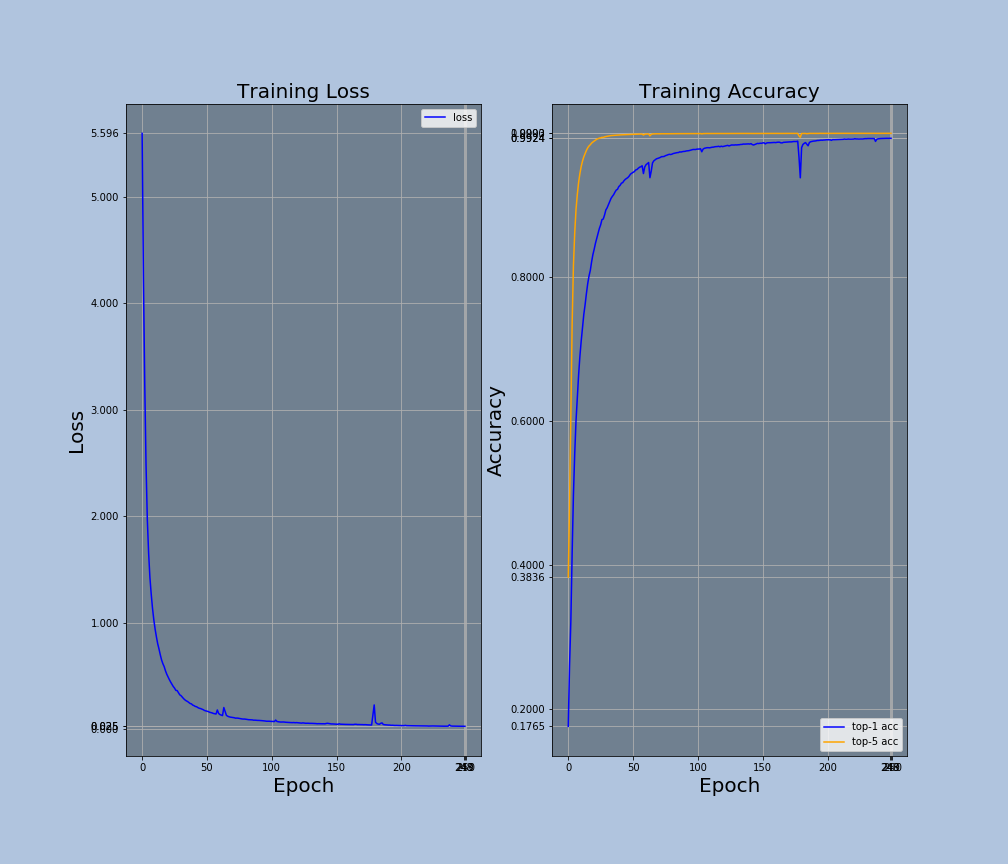

In [10]:
history = train(model, optimizer, criterion, n_epochs, device, ud_loader, lr_scheduler,
                prehistory=history, checkpoint_dir='.', checkpoint_basename='PoC', save_every=250)

---

## Loading the Best Model
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

In [12]:
loaded_dict = torch.load("./PoC_best.pth", map_location=device)
history = loaded_dict['history']
hyperparameters = loaded_dict['hyperparameters']
model_dict = loaded_dict['model_dict']
optimizer_dict = loaded_dict['optimizer_dict']
lr_dict = loaded_dict['lr_dict']

model.load_state_dict(model_dict)
optimizer.load_state_dict(optimizer_dict)

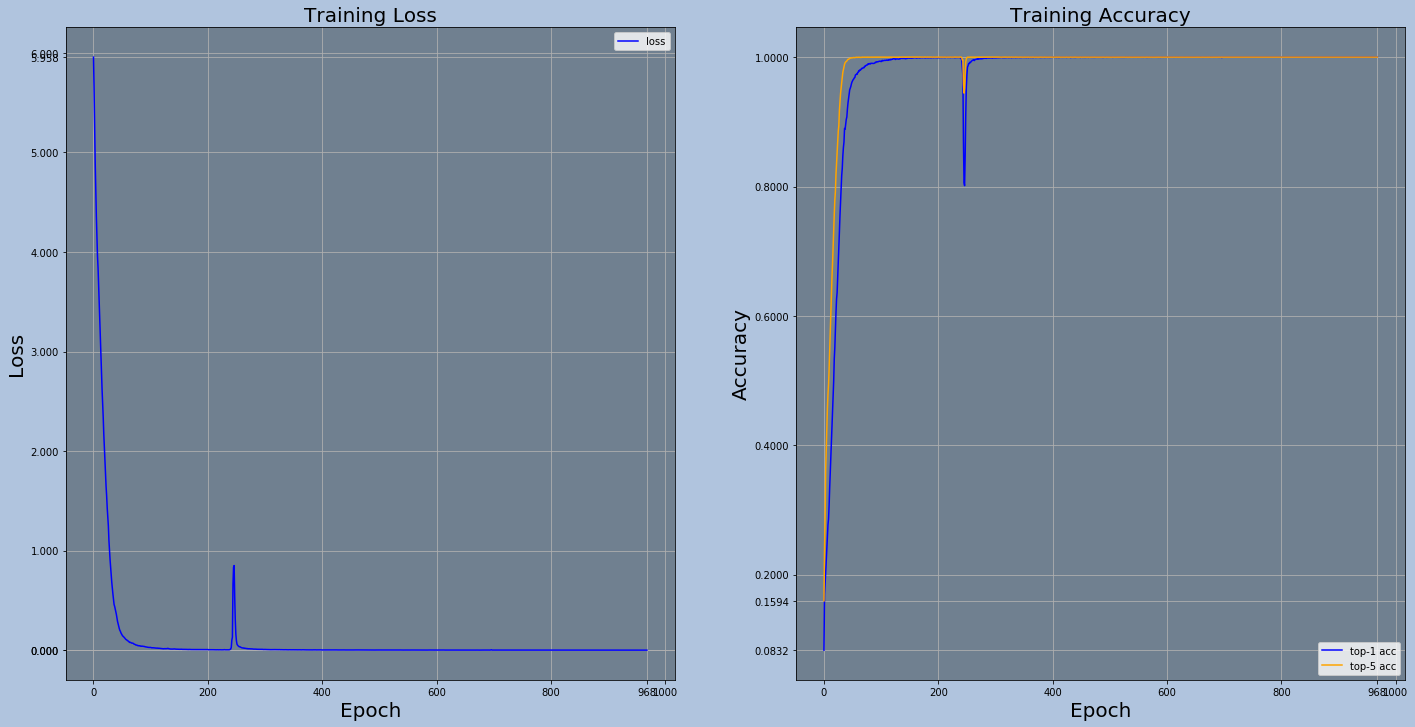

In [10]:
if True: # Plot the history of the loaded model
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12), facecolor=fig_bg_color)
    axes[0].set_facecolor(plot_bg_color)
    axes[0].grid(True)
    axes[0].set_title("Training Loss", fontsize=fontsize)
    axes[0].set_xlabel("Epoch", fontsize=fontsize)
    axes[0].set_ylabel("Loss", fontsize=fontsize)
    axes[0].plot(history['epoch'], history['loss'], color='blue', label='loss')
    axes[0].legend()
    axes[1].set_facecolor(plot_bg_color)
    axes[1].grid(True)
    axes[1].set_title("Training Accuracy", fontsize=fontsize)
    axes[1].set_xlabel("Epoch", fontsize=fontsize)
    axes[1].set_ylabel("Accuracy", fontsize=fontsize)
    axes[1].plot(history['epoch'], history['acc_1'], color='blue', label='top-1 acc')
    axes[1].plot(history['epoch'], history['acc_5'], color='orange', label='top-5 acc')
    axes[1].legend()

    xlim = axes[0].get_xlim()
    xticks = [tick for tick in axes[0].get_xticks() if xlim[0] <= tick <= xlim[1]]
    index = len(history['loss']) - 1 - history['loss'][::-1].index(max(history['loss']))
    if index not in xticks:
        xticks.append(index)
    index = len(history['loss']) - 1 - history['loss'][::-1].index(min(history['loss']))
    if index not in xticks:
        xticks.append(index)
    if history['epoch'][-1] not in xticks:
        xticks.append(history['epoch'][-1])
    axes[0].set_xticks(xticks)

    xlim = axes[1].get_xlim()
    xticks = [tick for tick in axes[1].get_xticks() if xlim[0] <= tick <= xlim[1]]
    index = len(history['acc_1']) - 1 - history['acc_1'][::-1].index(max(history['acc_1']))
    if index not in xticks:
        xticks.append(index)
    index = len(history['acc_1']) - 1 - history['acc_1'][::-1].index(min(history['acc_1']))
    if index not in xticks:
        xticks.append(index)
    index = len(history['acc_5']) - 1 - history['acc_5'][::-1].index(max(history['acc_5']))
    if index not in xticks:
        xticks.append(index)
    index = len(history['acc_5']) - 1 - history['acc_5'][::-1].index(min(history['acc_5']))
    if index not in xticks:
        xticks.append(index)
    if history['epoch'][-1] not in xticks:
        xticks.append(history['epoch'][-1])
    axes[1].set_xticks(xticks)

    ylim = axes[0].get_ylim()
    yticks = [tick for tick in axes[0].get_yticks() if ylim[0] <= tick <= ylim[1]]
    if max(history['loss']) not in yticks:
        yticks.append(max(history['loss']))
    if min(history['loss']) not in yticks:
        yticks.append(min(history['loss']))
    if history['loss'][-1] not in yticks:
        yticks.append(history['loss'][-1])
    axes[0].set_yticks(yticks)

    ylim = axes[1].get_ylim()
    yticks = [tick for tick in axes[1].get_yticks() if ylim[0] <= tick <= ylim[1]]
    if max(history['acc_1']) not in yticks:
        yticks.append(max(history['acc_1']))
    if min(history['acc_1']) not in yticks:
        yticks.append(min(history['acc_1']))
    if history['acc_1'][-1] not in yticks:
        yticks.append(history['acc_1'][-1])
    axes[1].set_yticks(yticks);
    ylim = axes[1].get_ylim()
    yticks = [tick for tick in axes[1].get_yticks() if ylim[0] <= tick <= ylim[1]]
    if max(history['acc_1']) not in yticks:
        yticks.append(max(history['acc_1']))
    if min(history['acc_1']) not in yticks:
        yticks.append(min(history['acc_1']))
    if history['acc_1'][-1] not in yticks:
        yticks.append(history['acc_1'][-1])
    if max(history['acc_5']) not in yticks:
        yticks.append(max(history['acc_5']))
    if min(history['acc_5']) not in yticks:
        yticks.append(min(history['acc_5']))
    if history['acc_5'][-1] not in yticks:
        yticks.append(history['acc_5'][-1])
    axes[1].set_yticks(yticks);

---

## Generation
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

### Sampling Function
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

In [13]:
def sample(model, input, hidden_states, top_k=5, temperature=1., return_as_tensor=False):
    assert top_k > 0
    assert temperature >= 0
    with torch.no_grad():
        output, hidden_states = model(input.view(1, -1), hidden_states)
        probs = output[0].softmax(dim=1)
    
    if temperature == 0 or top_k == 1:
        sampled = probs[-1].argmax(dim=0, keepdim=True)
    else:
        top_k_probs, top_k_args = probs[-1].topk(k=top_k, dim=0)
        top_idx = torch.multinomial(top_k_probs.pow(1 / temperature), 1)
        sampled = top_k_args.gather(dim=0, index=top_idx)
    
    if return_as_tensor:
        return sampled, hidden_states
    return sampled.item(), hidden_states

### Generation Function
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

In [14]:
def generate(model, length, starting_tokens=[], starting_len=100, top_k=5, temperature=1.):
    # `starting_len` is used to sample a sequence from ud_dataset when `staring_tokens` is not given.
    if starting_tokens:
        tokens = starting_tokens
        note = torch.tensor(starting_tokens, dtype=torch.long, device=device)
    else:
        tokens = ud_dataset[0][0][:starting_len].tolist()
        note = torch.tensor(tokens, dtype=torch.long, device=device)
    
    hidden_states = model.init_hidden(1)
    model.eval()
    
    with torch.no_grad():
        iterator = tqdm.tqdm(range(length), desc='Generating Tokens:', unit='token')
        for _ in iterator:
            note, hidden_states = sample(model, note, hidden_states, top_k, temperature, True)
            tokens.append(note.item())
    
    model.train()
    
    return tokens

def predict(model, ud_dataset, device=device):
    inputs, targets = ud_dataset[0]
    original = inputs[:1].tolist() + targets.tolist()
    
    model.to(device)
    
    seq_len = 2000
    
    predicted = [inputs[:1].item()]
    
    hidden_states = model.init_hidden(1)
    hidden_states = ([hidden.detach() for hidden in hidden_states[0]],
                     [cell.detach() for cell in hidden_states[1]])
    model.eval()
    
    iterable = zip(range(0, len(inputs), seq_len), range(seq_len, len(inputs) + seq_len - 1, seq_len))
    progress = tqdm.tqdm(iterable, desc='Processing Dataset:', total=inputs.size(0), unit='token')
    with torch.no_grad():
        for start, end in iterable:
            outputs, hidden_states = model(inputs.data[start:end].unsqueeze(0).to(device), hidden_states)
            predicted.extend(outputs.data.squeeze(0).argmax(dim=1, keepdim=False).cpu().tolist())
            if end <= inputs.size(0):
                progress.update(seq_len)
            else:
                progress.update(inputs.size(0) - start)
    
    model.train()
    
    return original, predicted

### Music Generation
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

In [15]:
def tokens_to_intlist(tokens, token_to_key_dict):
    if len(tokens) == 0:
        return []

    patterns = []
    intlist = []
    last_pattern = tuple()

    for token in tokens:
        pattern = token_to_key_dict[token]
        if pattern != tuple() and pattern[0] == "<REPEAT>":
            for _ in range(pattern[1]):
                patterns.append(last_pattern)
        else:
            patterns.append(pattern)
            last_pattern = pattern

    intlist.extend(patterns[0])
    for pattern in patterns[1:]:
        intlist.append(0)
        intlist.extend(pattern)
    
    return intlist

In [16]:
def intlist_to_text(intlist):
    return " ".join([str(int) for int in intlist])

In [17]:
original_tokens, predicted_tokens = predict(model, ud_dataset)
original_intlist, predicted_intlist = tokens_to_intlist(original_tokens, ud_dataset.tokens), tokens_to_intlist(predicted_tokens, ud_dataset.tokens)
original_text, predicted_text = intlist_to_text(original_intlist), intlist_to_text(predicted_intlist)

In [18]:
filebase = "./poc"

with open(filebase + "_orig.txt", 'w') as f:
    f.write(original_text)
with open(filebase + "_pred.txt", 'w') as f:
    f.write(predicted_text)

In [19]:
generated_tokens = generate(model, 50000, starting_tokens=[], starting_len=1, top_k=5, temperature=1.)
generated_intlist = tokens_to_intlist(generated_tokens, ud_dataset.tokens)
generated_text = intlist_to_text(generated_intlist)

print("Generated Tokens ({})".format(len(generated_tokens)))
print(generated_tokens[:100] + ['...'])
print("\nInt List ({})".format(len(generated_intlist)))
print(generated_intlist[:100] + ['...'])
print("\nText ({})".format(len(generated_text)))
print(generated_text[:500] + ' ...')

Generated Tokens (50001)
[2474, 7521, 254, 7522, 1922, 7521, 254, 7521, 0, 5066, 7521, 522, 7522, 1317, 7521, 522, 7521, 0, 3335, 7521, 497, 7522, 5067, 7522, 497, 2, 2236, 7522, 107, 7521, 829, 7522, 107, 7521, 26, 7522, 0, 7521, 768, 7522, 55, 7521, 1280, 7522, 105, 7521, 5068, 7522, 105, 3, 1084, 7522, 56, 7521, 5069, 7522, 189, 7521, 5070, 7522, 239, 7521, 5071, 7522, 299, 7521, 19, 7522, 0, 7521, 1317, 7522, 522, 7521, 1280, 7522, 105, 7521, 2479, 7522, 113, 7521, 553, 7522, 56, 7521, 1317, 7522, 522, 7521, 2680, 7522, 138, 7521, 1293, 7522, 152, 7521, 766, 7522, '...']

Int List (532247)
[42, 73, 78, 0, 42, 73, 78, 0, 73, 78, 0, 73, 78, 0, 73, 78, 0, 49, 73, 78, 0, 49, 73, 78, 0, 73, 78, 0, 73, 78, 0, 0, 47, 69, 73, 0, 47, 69, 73, 0, 69, 73, 0, 69, 73, 0, 69, 73, 0, 49, 69, 73, 0, 49, 69, 73, 0, 69, 73, 0, 69, 73, 0, 0, 42, 66, 69, 0, 42, 66, 69, 0, 66, 69, 0, 66, 69, 0, 66, 69, 0, 49, 66, 69, 0, 49, 66, 69, 0, 49, 66, 69, 0, 66, 69, 0, 69, 0, 47, 61, '...']

Text (1455699)
42 73

In [20]:
filepath = "./poc_gen.txt"

with open(filepath, 'w') as f:
    f.write(generated_text)

---

## Final Summary, Notes, and Thoughts
[(go to top)](#Undertale-&-Deltarune-Soundtrack-Generator)

---